## Transforms

* https://tfetimes.com/wp-content/uploads/2015/04/F.Dunn-I.Parberry-3D-Math-Primer-for-Graphics-and-Game-Development.pdf
* https://cs184.org/lecture/transforms-1

## Helpers

In [41]:
from math import sin, cos
import copy
from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/bfortuner/workplace/VisionQuest")
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def P(in_arr, out_arr):
    if type(out_arr) != np.ndarray:
        out_arr = np.array(out_arr)
    if type(in_arr) != np.ndarray:
        in_arr = np.array(in_arr)
    print(in_arr)
    print(out_arr)
    print('---')

def col2row(M, col):
    return [M[i][col] for i in range(len(M))]

def row2col(M, row):
    return [[num] for num in M[row]]

def get_shape(arr):
    shape = []
    while type(arr) in [list, np.ndarray]:
        shape.append(len(arr))
        arr = arr[0]
    return tuple(shape)

def dotV(v1, v2):
    # expecting two 1D vectors
    assert len(v1) == len(v2)
    return sum(a*b for a,b in zip(v1,v2))

def dotM(M1, M2):
    # Columns of M1 == Rows of M2
    assert len(M1[0]) == len(M2)
    out = [ [0 for col in M2[0]] for row in M1]
    for row in range(len(M1)):
        for col in range(len(M2[0])):
            v1 = M1[row]
            v2 = col2row(M2, col)
            out[row][col] = dotV(v1, v2)
    return out
    
def combine_transforms(transforms):
    base = transforms[0].matrix
    for transform in transforms[1:]:
        base = dotM(transform.matrix, base)
    return base

# https://www.mathsisfun.com/algebra/matrix-inverse-row-operations-gauss-jordan.html
# https://www.mathsisfun.com/algebra/matrix-inverse.html
# https://martin-thoma.com/solving-linear-equations-with-gaussian-elimination/
# http://matrix.reshish.com/inverCalculation.php
def invert(M):
    M = np.array(M)
    Inv = np.linalg.inv(M)
    return Inv.astype(list)

arr1 = np.array([[1]])
arr2 = np.array([
    [1, 2], 
    [3, 4]
])
arr3 = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
])
arr4 = np.array([
    [1, 2, 3],
    [4, 5, 6],
])
arr5 = np.array([
    [2,2],
    [3,0]
])
arr6 = np.array([
    [2],
    [-1],
    [8]
])
squares = [arr1, arr2, arr3, arr5]
rects = [arr1, arr2, arr3, arr4, arr5, arr6]

assert dotV([1,2,3],[3,3,0]) == 9
print(dotM(arr2,arr5) == np.dot(arr2,arr5))
print(dotM(arr3,arr6) == np.dot(arr3,arr6))
dotM(arr3,arr6),np.dot(arr3,arr6)

[[ True  True]
 [ True  True]]
[[ True]
 [ True]
 [ True]]


([[24], [51], [78]], array([[24],
        [51],
        [78]]))

## Primatives

In [43]:
class Point():
    def __init__(self, coords, color=(255,255,255)):
        """
        Homographic
        coords = [x, y, z ... w]
        """
        self.coords = coords
        self.color = color
    
    def T(self):
        return transpose(self.coords)
    
    def __repr__(self):
        return str(self.coords)
        
class Shape():
    def __init__(self, origin, points=None):
        """
        origin = [x, y, z]
        points = [Point(), Point()]
        """
        self.origin = origin
        self.points = [] if points is None else points
        
class Graph():
    def __init__(self, dims, shapes=None):
        self.dims = dims
        self.shapes = [] if shapes is None else shapes
    
    def plot(self):
        pass

class Transform():
    def __init__(self):
        self.matrix = [
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
        ]
    
    def col2row(self, obj):
        return [obj[i][0] for i in range(len(obj))]

    def row2col(self, obj):
        return [[num] for num in obj]
    
    def apply(self, obj, matrix):
        return dotM(matrix, obj)
    
    def __call__(self, obj, matrix=None):
        obj = copy.deepcopy(obj)
        if matrix is None:
            matrix = self.matrix
        if type(obj) == Point:
            out = self.apply(self.row2col(obj.coords), matrix)
            obj.coords = self.col2row(out)
        elif type(obj) == Shape:
            for p in obj.points:
                out = self.apply(self.row2col(p.coords), matrix)
                p.coords = self.col2row(out)
        elif type(obj) in [list, np.ndarray]:
            shape = get_shape(obj)
            if len(shape) == 1:
                out = self.apply(self.row2col(obj), matrix)
                obj = self.col2row(out)
            else:
                obj = self.apply(obj, matrix)
        else:
            print("{:s} Not supported".format(type(obj)))
        return obj      

## 2D Transforms

### Transpose

In [44]:
def transpose2d(arr):
    T = []
    for col in range(len(arr[0])):
        new_row = [arr[i][col] for i in range(len(arr))]
        T.append(new_row)
    return T

def transpose(arr):
    shape = get_shape(arr)
    if len(shape) == 1:
        return transpose2d([arr])
    elif len(shape) == 2:
        return transpose2d(arr)
    else:
        raise Exception("Higher dims not supported")
        
class Transpose2D(Transform):
    def __init__(self):
        super().__init__()
        self.matrix = [
            [0, 1, 0],
            [1, 0, 0],
            [0, 0, 1 ]
        ]     

A1 = [[1,2,3],
      [4,5,6],
      [7,8,9]]
A2 = [1,2,3]
A3 = [[1],[2],[3]]
# P(A1, transpose(A1))
# P(A2, transpose(A2))
# P(A3, transpose(A3))
# print("----")
# P(A1, Transpose2D()(A1))
# P(A2, Transpose2D()(A2))
# P(A3, Transpose2D()(A3))

### Reflect

In [45]:
class Reflect2D(Transform):
    def __init__(self, h=False, v=False):
        super().__init__()
        Rx = -1 if h else 1
        Ry = -1 if v else 1
        self.matrix = [
            [Rx, 0, 0],
            [0, Ry, 0],
            [0, 0, 1 ]
        ]

In [46]:
r = Reflect2D(h=True, v=True)
r([1,2,1])

[-1, -2, 1]

### Translate

In [47]:
class Translate2D(Transform):
    def __init__(self, Tx, Ty):
        super().__init__()
        self.matrix = [
            [1, 0, Tx],
            [0, 1, Ty],
            [0, 0,  1]
        ]

In [48]:
t = Translate2D(1,1)
t([1,1,1])

[2, 2, 1]

### Flip

In [49]:
class Flip2D(Transform):
    def __init__(self, xmax, ymax, h=False, v=False):
        super().__init__()
        self.reflect = Reflect2D(h, v)
        self.Tx = xmax if h else 0
        self.Ty = ymax if v else 0
        self.translate = Translate2D(self.Tx, self.Ty)
        self.matrix = combine_transforms([
            self.reflect, 
            self.translate
        ])

In [50]:
vflip = Flip2D(4, 4, True, False)
vflip([1, 1, 1])

[3, 1, 1]

### Scale

In [51]:
class Scale2D(Transform):
    def __init__(self, Sx, Sy):
        super().__init__()
        self.matrix = [
            [Sx, 0, 0],
            [0, Sy, 0],
            [0, 0,  1]
        ]

In [52]:
s = Scale2D(2,4)
s([1,1,1])

[2, 4, 1]

### Shear

In [53]:
class Shear2D(Transform):
    def __init__(self, Sx, Sy):
        super().__init__()
        self.matrix = [
            [1, Sx, 0],
            [Sy, 1, 0],
            [0,  0, 1]
        ]

In [54]:
s = Shear2D(3,1)
s([1,2,1])

[7, 3, 1]

### Rotate

* https://cs184.org/lecture/transforms-1/slide_030
* https://stackoverflow.com/questions/9875964/python-converting-radians-to-degrees
* https://en.wikipedia.org/wiki/Rotation_matrix
* https://betterexplained.com/articles/intuitive-guide-to-angles-degrees-and-radians/
* Why is it working backwards from what I expect? And only works in one direction?

In [55]:
class Rotate2D(Transform):
    def __init__(self, degrees):
        super().__init__()
        assert abs(degrees) >= 0
        assert abs(degrees) <= 360.0
        self.radians = math.radians(degrees)
        print("Degrees", degrees, "Radians", self.radians)
        self.matrix = [
            [cos(self.radians),  sin(self.radians), 0],
            [-sin(self.radians), cos(self.radians), 0],
            [0,                                  0, 1]
        ]

class FixedRotate2D(Transform):
    def __init__(self, degrees):
        assert abs(degrees) in [0, 90, 180, 270, 360]
        self.matrix = self.make_matrix(degrees)
    
    def make_matrix(self, degrees):
        if degrees in [90, -270]:
            return [
                [0, -1, 0],
                [1,  0, 0],
                [0,  0, 1],
            ]
        elif degrees in [180, -180]:
            return [
                [-1, 0, 0],
                [0, -1, 0],
                [0,  0, 1],
            ]
            
        elif degrees in [-90, 270]:
            return [
                [0,  1, 0],
                [-1, 0, 0],
                [0,  0, 1],
            ]
        else:
            return [
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]
        
class CenterRotate2D(Transform):
    def __init__(self, angle_degrees, origin, center):
        super().__init__()
        self.Tx = center[0]
        self.Ty = center[1]
        self.matrix = combine_transforms([
            Translate2D(-self.Tx, -self.Ty),
            Rotate2D(angle_degrees),
            Translate2D(self.Tx, self.Ty)
        ])

In [56]:
r = Rotate2D(90)
cr = CenterRotate2D(90, origin=(0,0), center=(2,2))
r([1,1,1]), cr([1,1,1])
cr = CenterRotate2D(90, origin=(0,0), center=(2,2))
cr([3,3,1])

print(FixedRotate2D(90)([1,0,1]))
print(FixedRotate2D(90)([0,1,1]))

print(FixedRotate2D(180)([1,0,1]))
print(FixedRotate2D(180)([0,1,1]))

print(FixedRotate2D(270)([1,0,1]))
print(FixedRotate2D(270)([0,1,1]))

Degrees 90 Radians 1.5707963267948966
Degrees 90 Radians 1.5707963267948966
Degrees 90 Radians 1.5707963267948966
[0, 1, 1]
[-1, 0, 1]
[-1, 0, 1]
[0, -1, 1]
[0, -1, 1]
[1, 0, 1]


## Coordinate Space

In [57]:
class CoordinateSpace(Transform):
    def __init__(self, origin, transforms):
        self.origin = origin
        self.matrix = combine_transforms(
            transforms
        )
        self.inverse = invert(
            self.matrix
        )
    
    def coord2World(self, obj):
        return super().__call__(obj, self.matrix)
        
    def world2Coord(self, obj):
        return super().__call__(obj, self.inverse)
    
class NumpyWorld():
    def __init__(self, origin, width, height):
        self.width = width
        self.height = height
        self.origin = origin
        self.coord_space = self.make_coord_space()

    def make_coord_space(self):
        transforms = [
            Translate2D(self.origin[0], self.origin[1]),
            Transpose2D(),
            Flip2D(self.width, self.height, h=True),
        ]
        return CoordinateSpace(self.origin, transforms)

    def rasterize(self, point):
        p = self.coord_space.coord2World(point)
        p.coords = [int(c) for c in p.coords]
        return p
        
    def plot_points(self, points):
        arr = np.ones((self.width, self.height))
        for p in points:
            p = self.rasterize(p)
            x,y,w = p.coords
            arr[x][y] = 0
        plt.imshow(arr, cmap='gray')
        plt.title(str(tuple(points)[:3]))
        plt.grid()
    #     plt.axvline()
    #     plt.axhline(y=h)
        plt.autoscale(enable=False)
#         plt.xticks(range(self.width), (range(1, 11)))
#         plt.yticks(range(self.height), (range(10,-1,-1)))
        #plt.gca().invert_yaxis()
        plt.show()

In [58]:
WORLD_ORIGIN_X = 10
WORLD_ORIGIN_Y = 10
WORLD_ORIGIN = (WORLD_ORIGIN_X, WORLD_ORIGIN_Y)
WORLD_WIDTH_PIXELS = 10
WORLD_HEIGHT_PIXELS = 10
DISPLAY_WIDTH_PIXELS = 20
DISPLAY_HEIGHT_PIXELS = 20
world = NumpyWorld(WORLD_ORIGIN, DISPLAY_WIDTH_PIXELS, DISPLAY_HEIGHT_PIXELS)

In [59]:
P(world.coord_space.matrix, world.coord_space.inverse)
P(world.coord_space.coord2World(Point([1,1,1])), 
  world.coord_space.world2Coord(Point([3,0,1])))

[[ 0 -1 10]
 [ 1  0 10]
 [ 0  0  1]]
[[0.0 1.0 -10.0]
 [-1.0 0.0 10.0]
 [0.0 0.0 1.0]]
---
[9, 11, 1]
[-10.0, 7.0, 1.0]
---


## Rasterize

In [60]:
# Float Points --> integer Pixel coords for plotting

def rasterize(point, world):
    point = world.coord2World(point)
    point.coords = [int(c) for c in point.coords]
    return point

## Plots

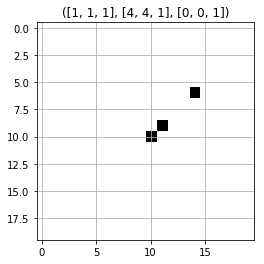

In [61]:
points = [Point([1,1,1]), Point([4,4,1]), Point([0,0,1])]
world.plot_points(points)

### Test Rotate

Angle 0
Input point [1, 1, 1]
Degrees 0 Radians 0.0
Rotated point [1, 1, 1]
Rounded point [1, 1, 1]


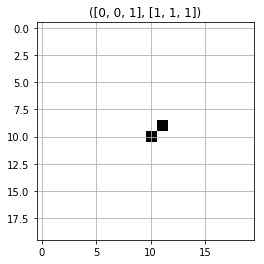

Angle 90
Input point [1, 1, 1]
Degrees 90 Radians 1.5707963267948966
Rotated point [-1, 1, 1]
Rounded point [-1, 1, 1]


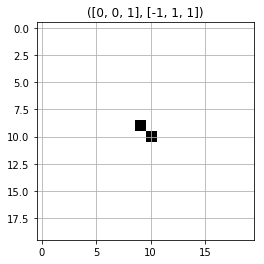

Angle 180
Input point [1, 1, 1]
Degrees 180 Radians 3.141592653589793
Rotated point [-1, -1, 1]
Rounded point [-1, -1, 1]


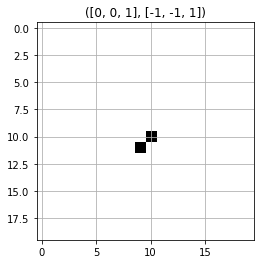

Angle 270
Input point [1, 1, 1]
Degrees 270 Radians 4.71238898038469
Rotated point [1, -1, 1]
Rounded point [1, -1, 1]


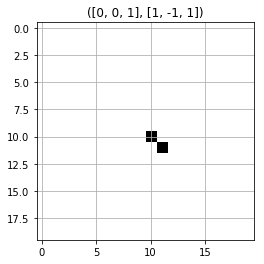

Angle 360
Input point [1, 1, 1]
Degrees 360 Radians 6.283185307179586
Rotated point [1, 1, 1]
Rounded point [1, 1, 1]


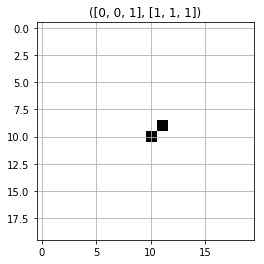

In [62]:
x_center = 0
y_center = 0
center = Point([x_center, y_center, 1])
for angle in [0, 90, 180, 270, 360]:
    print("Angle", angle)
    point = Point([1,1,1])
    print("Input point", point)
    centerRotate = CenterRotate2D(angle, origin=(0,0), center=(x_center, y_center))
    centerRotate = FixedRotate2D(angle)
    point = centerRotate(point)
    print("Rotated point", point)
    #point.coords = [int(c) for c in point.coords]
    print("Rounded point", point)
    world.plot_points([center, point])

## 3D Transforms

### Primatives

### Transpose

In [63]:
## TODO

### Reflect

In [64]:
class Reflect3D(Transform):
    def __init__(self, x=False, y=False, z=False):
        super().__init__()
        Rx = -1 if x else 1
        Ry = -1 if y else 1
        Rz = -1 if z else 1
        self.matrix = [
            [Rx, 0, 0, 0],
            [0, Ry, 0, 0],
            [0, 0, Rz, 0],
            [0, 0,  0, 1]
        ]

In [65]:
Reflect3D(x=True)([1,2,3,1])

[-1, 2, 3, 1]

### Translate

In [66]:
class Translate3D(Transform):
    def __init__(self, x=0, y=0, z=0):
        super().__init__()
        self.matrix = [
            [1, 0, 0, x],
            [0, 1, 0, y],
            [0, 0, 1, z],
            [0, 0, 0, 1]
        ]

In [67]:
Translate3D(x=2,y=-2)([1,1,1,1])

[3, -1, 1, 1]

### Rotate

In [68]:
class Rotate3D(Transform):
    def __init__(self, degrees, axis_letter):
        super().__init__()
        assert axis_letter in ['x','y','z']
        self.radians = math.radians(degrees)
        print("Degrees", degrees, "Radians", self.radians)
        if axis_letter == 'x':
            self.matrix = [
                [1,                  0,                 0, 0],
                [0,  cos(self.radians), sin(self.radians), 0],

                [0, -sin(self.radians), cos(self.radians), 0],
                [0,                  0,                 0, 1]
            ]
        elif axis_letter == 'y':
            self.matrix = [
                [cos(self.radians), 0, -sin(self.radians), 0],
                [0,                 1,                  0, 0],
                [sin(self.radians), 0,  cos(self.radians), 0],
                [0,                 0,                  0, 1]
            ]

        elif axis_letter == 'z':
            self.matrix = [
                [cos(self.radians),  sin(self.radians), 0, 0],
                [-sin(self.radians), cos(self.radians), 0, 0],
                [0,                                  0, 1, 0],
                [0,                                  0, 0, 1]
            ]

        
class CenterRotate3D(Transform):
    def __init__(self, angle_degrees, axis_letter, center):
        super().__init__()
        self.Tx = center[0]
        self.Ty = center[1]
        self.Tz = center[2]
        self.matrix = combine_transforms([
            Translate3D(-self.Tx, -self.Ty, -self.Tz),
            Rotate3D(angle_degrees, axis_letter),
            Translate3D(self.Tx, self.Ty, self.Tz)
        ])

In [69]:
for letter in 'xyz':
    print(letter, Rotate3D(90, letter)([1,1,1,1]))

Degrees 90 Radians 1.5707963267948966
x [1, 1.0, -0.9999999999999999, 1]
Degrees 90 Radians 1.5707963267948966
y [-0.9999999999999999, 1, 1.0, 1]
Degrees 90 Radians 1.5707963267948966
z [1.0, -0.9999999999999999, 1, 1]


In [70]:
for letter in 'xyz':
    print(letter, CenterRotate3D(90, letter, (2,2,2,1))([1,1,1,1]))

Degrees 90 Radians 1.5707963267948966
x [1.0, 1.0, 3.0, 1.0]
Degrees 90 Radians 1.5707963267948966
y [3.0, 1.0, 1.0, 1.0]
Degrees 90 Radians 1.5707963267948966
z [1.0, 3.0, 1.0, 1.0]
